In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants, analysis
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
import matplotlib.pyplot as plt
import matplotlib as mpl
pd.options.mode.chained_assignment = None
%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150

In [2]:
pudl_engine  = pudl.db_connect_pudl()

### Pulling the required tables

In [3]:
# Bring in pudl IDs for all EIA plants
pudl_ids = g9 = analysis.simple_select('plants_eia', pudl_engine)

In [4]:
# Convert the generation_eia923 table into a dataframe
g9 = analysis.simple_select('generation_eia923', pudl_engine)
# Get yearly net generation by plant_id, year and generator_id
g9_summed = analysis.yearly_sum_eia(g9, 'net_generation_mwh')
g9_summed.reset_index(inplace=True)

In [5]:
# Convert the generators_eia860 table into a dataframe
g8 = analysis.simple_select('generators_eia860', pudl_engine)

# In order to use the energy source associated with each generator
g8_es = g8[['plant_id','generator_id', 'energy_source_1']]
g8_es = g8_es.rename(columns={'energy_source_1': 'energy_source'})
g8_es.drop_duplicates(['plant_id','generator_id'], inplace=True)

# In order to use the capacity of each generator
g8 = g8[['plant_id','plant_name', 'operator_name', 'state', 'generator_id','nameplate_capacity_mw','summer_capacity_mw','winter_capacity_mw','year']]
g8.rename(columns={'year': 'report_date'},inplace=True)

In [6]:
# # Cheating to duplicate 2015 EIA860 capacity factor data for 2016:
g8_2016 = g8.loc[g8['report_date'] == 2015]
g8_2016.report_date.replace([2015], [2016], inplace=True)
g8 = g8_2016.append(g8)

In [7]:
# Convert the fuel_receipts_costs_eia923 table into a dataframe
frc9 = analysis.simple_select('fuel_receipts_costs_eia923', pudl_engine)
frc9['fuel_cost'] = (frc9['fuel_quantity'] * frc9['average_heat_content'] * frc9['fuel_cost_per_mmbtu'])
frc9['mmbtu'] =  (frc9['fuel_quantity'] * frc9['average_heat_content'])

In [8]:
frc9.head(2)

,fuel_receipt_id,plant_id,report_date,contract_type,contract_expiration_date,energy_source,fuel_group,coalmine_id,supplier,fuel_quantity,average_heat_content,average_sulfur_content,average_ash_content,average_mercury_content,fuel_cost_per_mmbtu,primary_transportation_mode,secondary_transportation_mode,natural_gas_transport,fuel_cost,mmbtu
0,1,3,2009-01-01,C,2009-12-01,BIT,Coal,1.0,Alabama Coal,120393.0,24.0,1.0,12.0,NaN,6.311,RV,None,None,1.823521e+07,2889432.0
1,2,3,2009-01-01,C,2013-12-01,BIT,Coal,2.0,Interocean Coal,199388.0,23.0,1.0,9.5,NaN,3.503,RV,None,None,1.606449e+07,4585924.0


In [9]:
# Get yearly fuel cost by plant_id, year and energy_source
frc9_summed = analysis.yearly_sum_eia(frc9 , 'fuel_cost', columns=['plant_id','report_date','energy_source'])
frc9_summed = frc9_summed.reset_index()

In [10]:
frc9_mmbtu_summed = analysis.yearly_sum_eia(frc9 , 'mmbtu', columns=['plant_id','report_date','energy_source'])
frc9_mmbtu_summed = frc9_mmbtu_summed.reset_index()

In [11]:
frc9_summed = frc9_mmbtu_summed.merge(frc9_summed)
frc9_summed['fuel_cost_per_mmbtu_total'] = (frc9_summed.fuel_cost/frc9_summed.mmbtu)

In [12]:
frc9_summed.head()

,plant_id,report_date,energy_source,mmbtu,fuel_cost,fuel_cost_per_mmbtu_total
0,3,2009,BIT,8.784741e+07,3.019373e+08,3.437065
1,3,2009,NG,4.316773e+07,1.881205e+08,4.357896
2,3,2010,BIT,8.315514e+07,3.124745e+08,3.757729
3,3,2010,NG,5.171804e+07,2.463235e+08,4.762817
4,3,2011,BIT,4.714560e+07,2.025195e+08,4.295619


In [13]:
# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date','boiler_id'])
bf9_summed.reset_index(inplace=True)
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_plant_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date'])
bf9_plant_summed.reset_index(inplace=True)

In [14]:
# Convert the boiler_generator_assn_eia860 table into a dataframe
bga8 = analysis.simple_select('boiler_generator_assn_eia860', pudl_engine)
bga8.drop(['id','operator_id'],axis=1, inplace=True)
bga8.drop_duplicates(['plant_id','boiler_id','generator_id'],inplace=True)

In [15]:
# get the primary fuel for each plant (to be used to combine plants that have unassociated generators)
gf9 = analysis.simple_select('generation_fuel_eia923', pudl_engine)
primary_fuel9 = analysis.primary_fuel_gf_eia923(gf9).rename(columns={'year':'report_date'})

In [16]:
g9_summed.head()

,plant_id,report_date,generator_id,net_generation_mwh
0,3,2009,1,221908.0
1,3,2009,2,394031.0
2,3,2009,3,1286393.0
3,3,2009,4,1626547.0
4,3,2009,5,4513101.0


### Generating Capacity Factor

In [17]:
# merge the generation and capacity to calculate capacity factor
capacity_factor = g9_summed.merge(g8, on=['plant_id','generator_id','report_date'])
capacity_factor['capacity_factor'] = capacity_factor['net_generation_mwh']/(capacity_factor['nameplate_capacity_mw']*8760)

In [18]:
capacity_factor.head()

,plant_id,report_date,generator_id,net_generation_mwh,plant_name,operator_name,state,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
0,3,2011,1,312130.0,Barry,Alabama Power Co,AL,153.1,138.0,138.0,0.232732
1,3,2011,2,191475.0,Barry,Alabama Power Co,AL,153.1,137.0,137.0,0.142769
2,3,2011,3,710069.0,Barry,Alabama Power Co,AL,272.0,249.0,249.0,0.298008
3,3,2011,4,1175685.0,Barry,Alabama Power Co,AL,403.7,362.0,362.0,0.332451
4,3,2011,5,2264413.0,Barry,Alabama Power Co,AL,788.8,726.5,726.5,0.327706


In [19]:
# Replace unrealistic capacity factors with NaN: < 0 or > 1.5
capacity_factor.loc[capacity_factor['capacity_factor'] < 0, 'capacity_factor'] = np.nan
capacity_factor.loc[capacity_factor['capacity_factor'] >= 1.5, 'capacity_factor'] = np.nan

### Generating Fuel Cost, Part 1

In [20]:
# Merge the generation table with the generator table to include energy_source  
# Merge this net_gen table with frc9_summed to have fuel_cost_per_mmbtu_total associated
# with generators
net_gen = g9_summed.merge(g8_es, how='left', on=['plant_id','generator_id'])
fuel_cost_per_mmbtu = net_gen.merge(frc9_summed,how='left',on=['plant_id','report_date','energy_source'])

# Generating Heat Rate

## Boiler Generator Association Exploration

In [21]:
# This section generates heat rate from the generators
# of the plants that have any generators that are not
# included in the boiler generator association table (860)
# Because there are missing generators in the bga table,
# without lumping all of the heat input and generation
# from these plants together, the heat rates were off. 
# The vast majority of missing generators from the bga
# table seem to be the gas tubrine from combine cycle plants.
# This was generating heat rates for the steam generators
# alone, therefor much too low.

In [22]:
# All cenerators from the Boiler Generator Association table (860)
gens8 = bga8.drop_duplicates(subset=['plant_id','generator_id'])
# All cenerators from the generation table (923)/
gens9 = g9_summed.drop_duplicates(subset=['plant_id','generator_id','report_date'])

# See which generators are missing from the bga table
gens = gens9.merge(gens8, on=['plant_id', 'generator_id'], how="left")
gens.boiler_id = gens.boiler_id.astype(str)
gens['boiler_generator_assn'] = np.where(gens['boiler_id']=='nan', False, True)

# Create a list of plants that include any generators that are not in the bga table
unassociated_plants = gens[gens['boiler_generator_assn'] == False].\
                      drop_duplicates(subset=['plant_id','report_date']).\
                      drop(['generator_id', 'net_generation_mwh','boiler_id','boiler_generator_assn'],axis=1)
unassociated_plants['plant_assn'] = False

# Using these unassociated_plants, lable all the generators that
# are a part of plants that have generators that are not included
# in the bga table
gens = gens.merge(unassociated_plants, on=['plant_id','report_date'],how='left')
gens['plant_assn'] = gens.plant_assn.fillna(value=True)

# Using the associtated plants, extract the generator/boiler combos
# that represent complete plants at any time to preserve 
# associations (i.e. if a coal plant had its boilers and generators
# fully associated in the bga table in 2011 and then adds a
# combined cycle plant the coal boiler/gen combo will be saved). 
gens_complete = gens[['plant_id','generator_id','boiler_id','boiler_generator_assn','plant_assn']]
gens_complete = gens_complete[gens_complete['plant_assn'] == True].drop_duplicates(subset=['plant_id','generator_id','boiler_id'])
gens_complete['complete_assn'] = True
gens = gens.merge(gens_complete[['plant_id','generator_id','boiler_id','complete_assn']], how='left', on=['plant_id','generator_id','boiler_id'])
gens['complete_assn'] = gens.complete_assn.fillna(value=False)

## Associated Generators

In [23]:
# This section generates heat rate from the generators of
# the plants that have any generators that are included in
# the boiler generator association table (860)

In [24]:
generation_w_boilers = g9_summed.merge(bga8,how='left',on=['plant_id','generator_id'])

# get net generation per boiler
gb1 = generation_w_boilers.groupby(by=['plant_id','report_date','boiler_id'])
generation_w_boilers_summed = gb1.agg({'net_generation_mwh': np.sum})
generation_w_boilers_summed.reset_index(inplace=True)
generation_w_boilers_summed.rename(columns={'net_generation_mwh':'net_generation_mwh_boiler'}, inplace=True)

# get the generation per boiler/generator combo
gb2 = generation_w_boilers.groupby(by=['plant_id','report_date','boiler_id','generator_id'])
generation_w_bg_summed = gb2.agg({'net_generation_mwh': np.sum})
generation_w_bg_summed.reset_index(inplace=True)
generation_w_bg_summed.rename(columns={'net_generation_mwh':'net_generation_mwh_boiler_gen'}, inplace=True)

# squish them together
generation_w_boilers_summed = generation_w_boilers_summed.merge(generation_w_bg_summed,
                                                                how='left', on=['plant_id','report_date','boiler_id'])

# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date','boiler_id'])
bf9_summed.reset_index(inplace=True)

bg = bf9_summed.merge(bga8,how='left',on=['plant_id','boiler_id'])
bg = bg.merge(generation_w_boilers_summed, how='left', on=['plant_id','report_date', 'boiler_id', 'generator_id'])

# Use the proportion of the generation of each generator to allot mmBTU
bg['proportion_of_gen_by_boil_gen'] = bg['net_generation_mwh_boiler_gen'] / bg['net_generation_mwh_boiler']
bg['fuel_consumed_mmbtu_per_gen'] = bg['proportion_of_gen_by_boil_gen'] * bg['fuel_consumed_mmbtu']

# Get yearly fuel_consumed_mmbtu by plant_id, year and generator_id
bg_gb = bg.groupby(by=['plant_id','report_date','generator_id'])
bg_summed = bg_gb.agg({'fuel_consumed_mmbtu_per_gen':np.sum})
bg_summed.reset_index(inplace=True)

# Calculate heat rate
heat_rate = bg_summed.merge(g9_summed,how='left',on=['plant_id', 'report_date', 'generator_id'])
heat_rate['heat_rate_mmbtu_mwh'] = heat_rate['fuel_consumed_mmbtu_per_gen'] / heat_rate['net_generation_mwh']

# Importing the plant association tag to filter out the
# generators that are a part of plants that aren't in the bga table
heat_rate = heat_rate.merge(gens[['plant_id','report_date','generator_id','complete_assn','plant_assn','boiler_id', 'boiler_generator_assn']], on=['plant_id','report_date','generator_id'])

heat_rate_assn = heat_rate[heat_rate['complete_assn'] == True]

In [25]:
# If heat rate is <1, then don't include this generator in the Associated group
heat_rate_assn.loc[heat_rate_assn.heat_rate_mmbtu_mwh < 1, 'complete_assn'] = False
heat_rate_assn = heat_rate_assn[heat_rate_assn.complete_assn == True]

In [26]:
# Create list of generators that have been recategorized as unassociated so as to include them in Unassociated calculations
unassociated = heat_rate_assn.loc[heat_rate_assn['complete_assn'] == False]
unassociated.drop_duplicates(['plant_id', 'generator_id'], inplace=True)

## Unassociated Generators

In [27]:
# Get a list of generators from plants with unassociated plants
#gens_unassn_plants = gens[gens['plant_assn'] == False]
gens_unassn_plants = gens[gens['complete_assn'] == False]
gens_unassn_plants = pd.concat([gens_unassn_plants, unassociated])
gens_unassn_plants.drop_duplicates(['plant_id', 'generator_id'], inplace=True)

# Sum the yearly net generation for these plants
gup_gb = gens_unassn_plants.groupby(by=['plant_id','report_date'])
gens_unassn_plants_summed = gup_gb.agg({'net_generation_mwh': np.sum})
gens_unassn_plants_summed.reset_index(inplace=True)

# Pull in mmbtu to calculate heat rate by plant
unassn_plants = gens_unassn_plants_summed.merge(bf9_plant_summed, on=['plant_id','report_date'])
unassn_plants['heat_rate_mmbtu_mwh'] = unassn_plants['fuel_consumed_mmbtu'] / unassn_plants['net_generation_mwh']

# Merge these plant level heat heat rates with the unassociated generators
# Assign heat rates to generators across the plants with unassociated generators
heat_rate_unassn = gens_unassn_plants.merge(unassn_plants[['plant_id','report_date','heat_rate_mmbtu_mwh']], on=['plant_id','report_date'],how='left')
heat_rate_unassn.drop(['boiler_id','boiler_generator_assn'],axis=1,inplace=True)

In [28]:
gens_unassn_plants[gens_unassn_plants['plant_id'] == 3]

,boiler_generator_assn,boiler_id,complete_assn,fuel_consumed_mmbtu_per_gen,generator_id,heat_rate_mmbtu_mwh,net_generation_mwh,plant_assn,plant_id,report_date
40,False,nan,False,NaN,A1CT,NaN,838358.0,False,3,2014
41,False,nan,False,NaN,A1CT2,NaN,849336.0,False,3,2014
43,False,nan,False,NaN,A2C1,NaN,830654.0,False,3,2014
44,False,nan,False,NaN,A2C2,NaN,852641.0,False,3,2014


## Pull the Associated and Unassociated Generators

In [29]:
heat_rate_all = heat_rate_assn.append(heat_rate_unassn)
heat_rate_all.sort_values(by=['plant_id','report_date','generator_id'],inplace=True)
heat_rate_all.loc[heat_rate_all['heat_rate_mmbtu_mwh'] < 5, 'heat_rate_mmbtu_mwh'] = np.nan

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


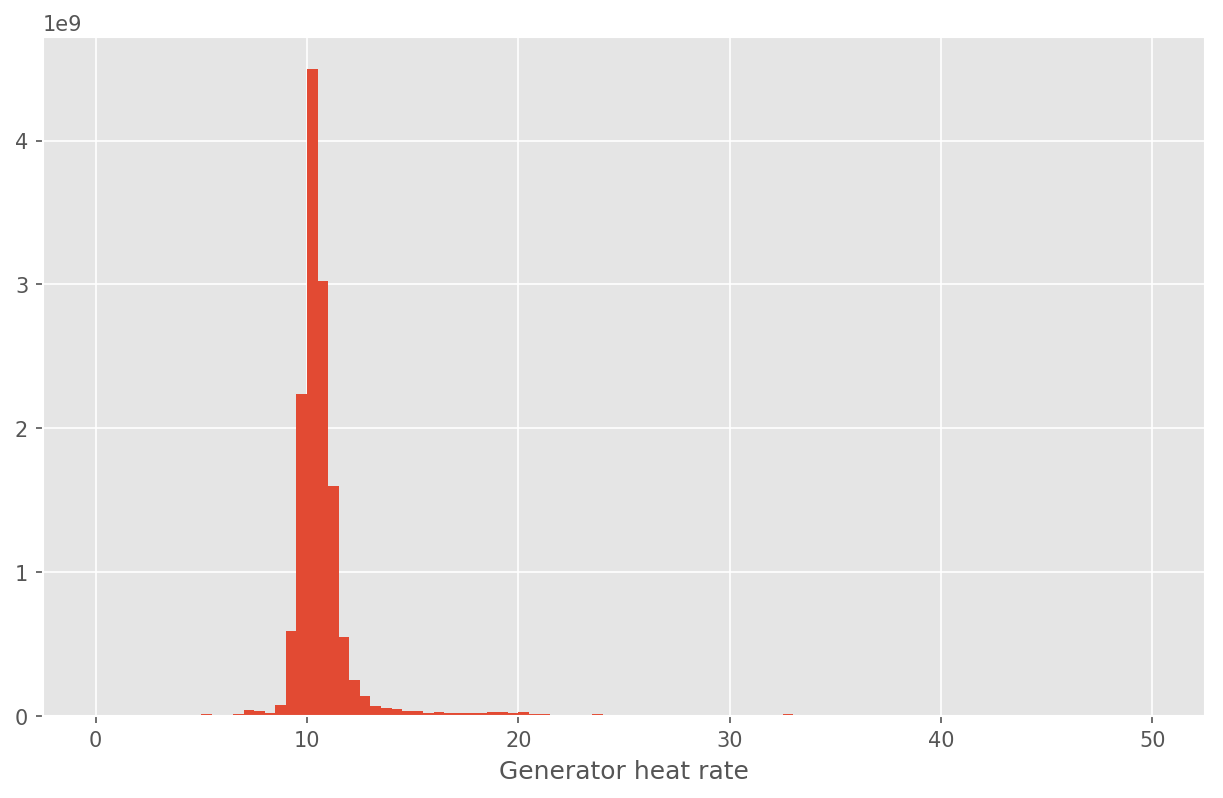

In [30]:
plt.hist(heat_rate_all.heat_rate_mmbtu_mwh, range=[0,50],bins=100,weights=heat_rate_all.net_generation_mwh)
#heat_rate['heat_rate_mmbtu_mwh'].plot(kind='hist', bins=100, range=[-20,70])
plt.xlabel('Generator heat rate')
plt.show()

### Merge fields together

In [31]:
mcoe_by_generator = fuel_cost_per_mmbtu.merge(heat_rate_all,on=['plant_id','report_date','generator_id'])

In [32]:
mcoe_by_generator = mcoe_by_generator.merge(capacity_factor, on=['plant_id','report_date','generator_id'])

In [33]:
# Drop extraneous net_generation columns, and fuel_cost column because it is sum for whole plant
mcoe_by_generator.drop('net_generation_mwh_y', axis=1, inplace=True)
mcoe_by_generator.drop('net_generation_mwh_x', axis=1, inplace=True)
mcoe_by_generator.drop('fuel_cost', axis=1, inplace=True)

In [34]:
mcoe_by_generator.head(1)

,plant_id,report_date,generator_id,energy_source,mmbtu,fuel_cost_per_mmbtu_total,boiler_generator_assn,boiler_id,complete_assn,fuel_consumed_mmbtu_per_gen,...,heat_rate_mmbtu_mwh_y,plant_assn,net_generation_mwh,plant_name,operator_name,state,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
0,3,2011,1,BIT,4.714560e+07,4.295619,True,1,True,3565315.033,...,NaN,True,312130.0,Barry,Alabama Power Co,AL,153.1,138.0,138.0,0.232732


### Filter to include only plants >= 10 MW

In [35]:
# Now, let's grab only those plants larger than 50MW
mcoe_by_generator = mcoe_by_generator[mcoe_by_generator['nameplate_capacity_mw']>=10]

In [36]:
mcoe_by_generator.head(1)

,plant_id,report_date,generator_id,energy_source,mmbtu,fuel_cost_per_mmbtu_total,boiler_generator_assn,boiler_id,complete_assn,fuel_consumed_mmbtu_per_gen,...,heat_rate_mmbtu_mwh_y,plant_assn,net_generation_mwh,plant_name,operator_name,state,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
0,3,2011,1,BIT,4.714560e+07,4.295619,True,1,True,3565315.033,...,NaN,True,312130.0,Barry,Alabama Power Co,AL,153.1,138.0,138.0,0.232732


### Generating Fuel Cost, Part 2

In [37]:
# Calculate fuel cost per mwh using average fuel cost given year, plant, fuel type; divide by generator-specific heat rate
mcoe_by_generator['fuel_cost_per_mwh'] = (mcoe_by_generator['fuel_cost_per_mmbtu_total'] * mcoe_by_generator['heat_rate_mmbtu_mwh'])

In [38]:
mcoe_by_generator.head(1)

,plant_id,report_date,generator_id,energy_source,mmbtu,fuel_cost_per_mmbtu_total,boiler_generator_assn,boiler_id,complete_assn,fuel_consumed_mmbtu_per_gen,...,plant_assn,net_generation_mwh,plant_name,operator_name,state,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor,fuel_cost_per_mwh
0,3,2011,1,BIT,4.714560e+07,4.295619,True,1,True,3565315.033,...,True,312130.0,Barry,Alabama Power Co,AL,153.1,138.0,138.0,0.232732,49.066847


### Add PUDL plant IDs

In [39]:
mcoe_by_generator = mcoe_by_generator.merge(pudl_ids[['plant_id','plant_id_pudl']], on=['plant_id'])

In [40]:
mcoe_by_generator.head(1)

,plant_id,report_date,generator_id,energy_source,mmbtu,fuel_cost_per_mmbtu_total,boiler_generator_assn,boiler_id,complete_assn,fuel_consumed_mmbtu_per_gen,...,net_generation_mwh,plant_name,operator_name,state,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor,fuel_cost_per_mwh,plant_id_pudl
0,3,2011,1,BIT,4.714560e+07,4.295619,True,1,True,3565315.033,...,312130.0,Barry,Alabama Power Co,AL,153.1,138.0,138.0,0.232732,49.066847,32


In [41]:
mcoe_by_generator.rename(columns={'plant_id': 'plant_id_eia'}, inplace=True)

## Export the data frame

In [42]:
# rearrange columns
mcoe_by_generator = mcoe_by_generator[[
    'plant_id_eia', 
    'plant_id_pudl',
    'plant_name',
    'operator_name', 
    'state', 
    'report_date', 
    'generator_id', 
    'energy_source',
    'fuel_cost_per_mmbtu_total',
    'fuel_consumed_mmbtu_per_gen',
    'heat_rate_mmbtu_mwh', 
    'plant_assn', 
    'net_generation_mwh', 
    'fuel_cost_per_mwh',
    'nameplate_capacity_mw', 
    'summer_capacity_mw',
    'winter_capacity_mw', 
    'capacity_factor']]

In [43]:
mcoe_annotations = pd.read_csv('mcoe_field_annotations.csv')
mcoe_notes = pd.read_csv('mcoe_notes.csv')

In [44]:
# to export all the data
xlsx_writer = pd.ExcelWriter('EIA_mcoe_inputs_2011-2016.xlsx')
mcoe_by_generator.to_excel(xlsx_writer, sheet_name='MCOE by Generator', index=False, na_rep='NA')
mcoe_annotations.to_excel(xlsx_writer, sheet_name='MCOE Annotations', index=False)
mcoe_notes.to_excel(xlsx_writer, sheet_name='MCOE Notes', index=False)

xlsx_writer.save()

In [45]:
mcoe_by_generator.describe()  

,plant_id_eia,plant_id_pudl,report_date,fuel_cost_per_mmbtu_total,fuel_consumed_mmbtu_per_gen,heat_rate_mmbtu_mwh,net_generation_mwh,fuel_cost_per_mwh,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
count,13388.000000,13388.000000,13388.000000,5498.000000,1.184700e+04,10975.000000,1.338800e+04,4774.000000,13388.000000,13258.000000,13244.000000,13375.000000
mean,18297.011876,2280.079175,2013.375261,3.254763,9.676465e+06,23.350593,8.076639e+05,44.931366,217.938497,201.459602,204.039761,0.376852
std,22579.734216,1782.805574,1.606569,2.030067,1.348119e+07,117.958757,1.275390e+06,269.512339,245.306796,232.213062,233.841097,0.264277
min,3.000000,1.000000,2011.000000,0.652026,-1.354165e+05,5.035315,-8.758000e+03,6.759358,10.000000,0.100000,0.500000,0.000000
25%,1934.000000,526.000000,2012.000000,2.172442,1.205214e+06,10.729066,6.364372e+04,22.654732,36.200000,31.000000,31.000000,0.125203
50%,6043.000000,2202.000000,2013.000000,2.846228,3.913392e+06,12.248513,2.415825e+05,30.419188,115.700000,107.000000,108.000000,0.383498
75%,50406.000000,3598.000000,2015.000000,3.959000,1.132535e+07,19.354452,8.712822e+05,43.148012,312.075000,285.000000,290.000000,0.592854
max,60100.000000,10296.000000,2016.000000,46.541617,9.913044e+07,6428.933014,1.002464e+07,17795.667991,1425.600000,1432.000000,1490.000000,1.432999


In [46]:
### Let's look at some data

In [47]:
mcoe_by_generator[mcoe_by_generator['plant_id_eia'] == 1893]

,plant_id_eia,plant_id_pudl,plant_name,operator_name,state,report_date,generator_id,energy_source,fuel_cost_per_mmbtu_total,fuel_consumed_mmbtu_per_gen,heat_rate_mmbtu_mwh,plant_assn,net_generation_mwh,fuel_cost_per_mwh,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
3267,1893,67,Clay Boswell,Minnesota Power Inc,MN,2011,1,SUB,1.531591,4.097974e+06,11.185802,True,366355.0,17.132070,75.0,68.0,68.0,0.557618
3268,1893,67,Clay Boswell,Minnesota Power Inc,MN,2011,2,SUB,1.531591,4.986235e+06,11.152193,True,447108.0,17.080595,75.0,67.0,67.0,0.680530
3269,1893,67,Clay Boswell,Minnesota Power Inc,MN,2011,3,SUB,1.531591,2.564162e+07,10.482688,True,2446092.0,16.055188,364.5,360.5,360.5,0.766075
3270,1893,67,Clay Boswell,Minnesota Power Inc,MN,2011,4,SUB,1.531591,4.213513e+07,10.427685,True,4040699.0,15.970945,558.0,428.0,428.0,0.826643
3271,1893,67,Clay Boswell,Minnesota Power Inc,MN,2012,1,SUB,1.572640,5.174980e+06,11.070163,True,467471.0,17.409384,75.0,67.6,67.6,0.711524
3272,1893,67,Clay Boswell,Minnesota Power Inc,MN,2012,2,SUB,1.572640,5.354967e+06,11.228206,True,476921.0,17.657929,75.0,68.1,68.1,0.725907
3273,1893,67,Clay Boswell,Minnesota Power Inc,MN,2012,3,SUB,1.572640,2.526966e+07,10.505866,True,2405291.0,16.521947,364.5,361.5,361.5,0.753297
3274,1893,67,Clay Boswell,Minnesota Power Inc,MN,2012,4,SUB,1.572640,4.048423e+07,10.351390,True,3910994.0,16.279013,558.0,467.5,467.5,0.800108
3275,1893,67,Clay Boswell,Minnesota Power Inc,MN,2013,1,SUB,1.573859,4.857294e+06,11.038175,True,440045.0,17.372531,75.0,67.6,67.6,0.669779
3276,1893,67,Clay Boswell,Minnesota Power Inc,MN,2013,2,SUB,1.573859,5.282646e+06,11.185578,True,472273.0,17.604522,75.0,68.1,68.1,0.718833


/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


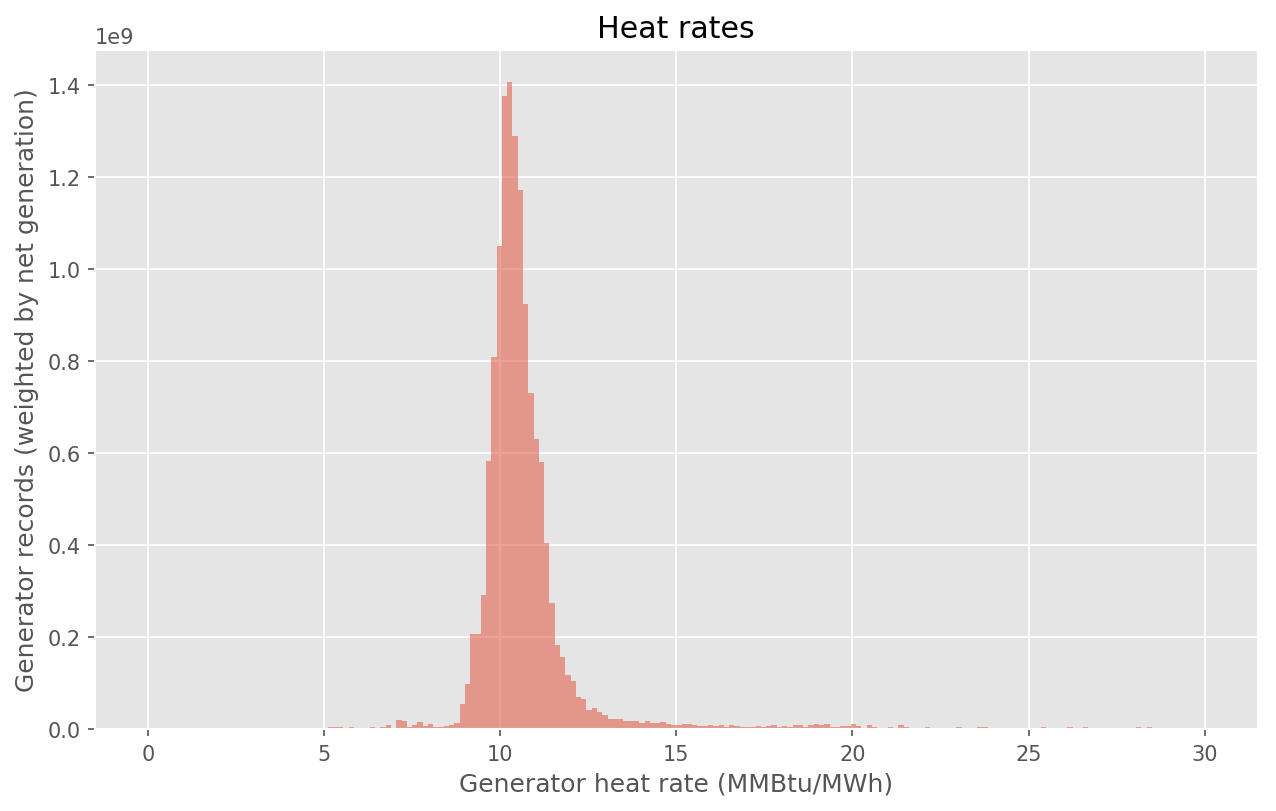

In [48]:
# Take a look at heat rates
plt.hist(heat_rate_all.heat_rate_mmbtu_mwh, range=[0,30],bins=200,weights=heat_rate_all.net_generation_mwh, alpha=0.5)
plt.xlabel('Generator heat rate (MMBtu/MWh)')
plt.ylabel("Generator records (weighted by net generation)")
plt.title("Heat rates")
plt.show()

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)
/home/alana/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


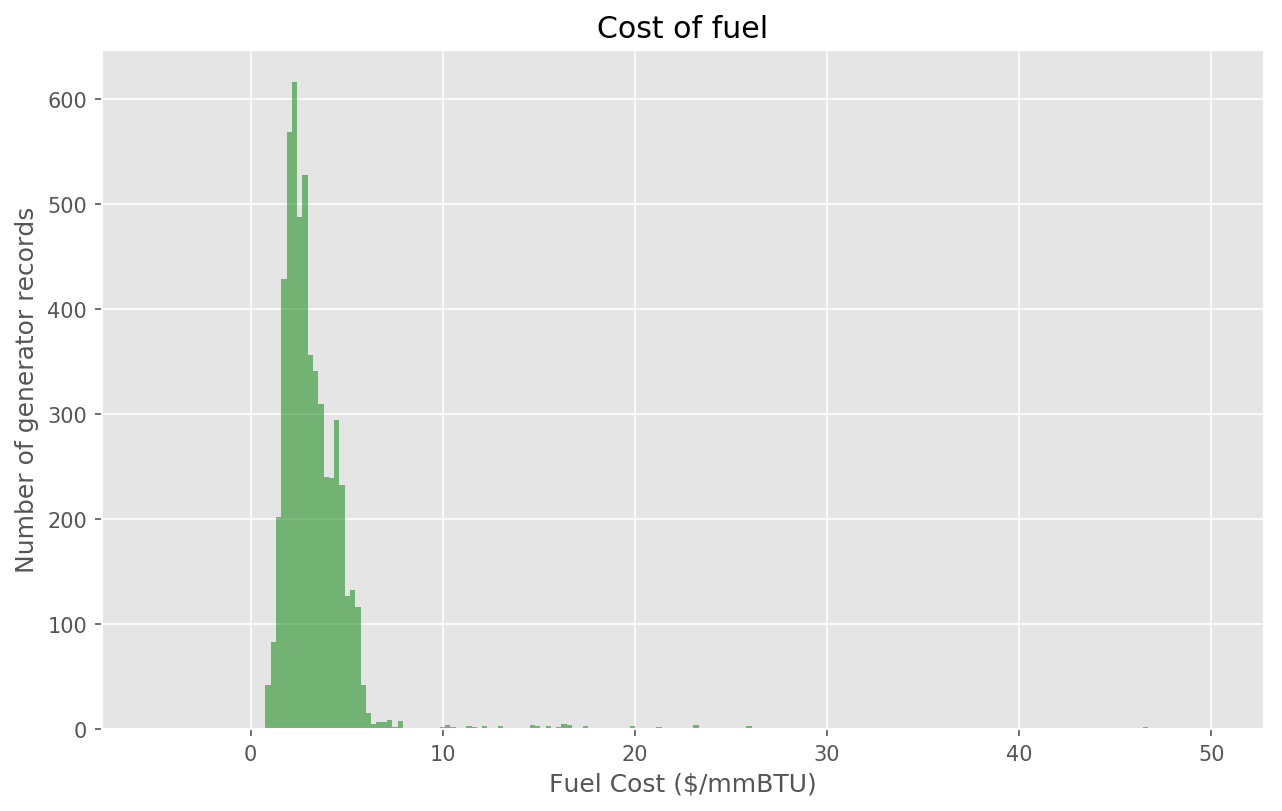

In [49]:
#quick look at spread in fuel_cost_per_mmbtu
plt.hist(mcoe_by_generator.fuel_cost_per_mmbtu_total, range=(-5,50), bins=200, alpha=0.5, color='green')
plt.xlabel("Fuel Cost ($/mmBTU)")
plt.ylabel("Number of generator records")
plt.title("Cost of fuel")
plt.legend();

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)
/home/alana/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


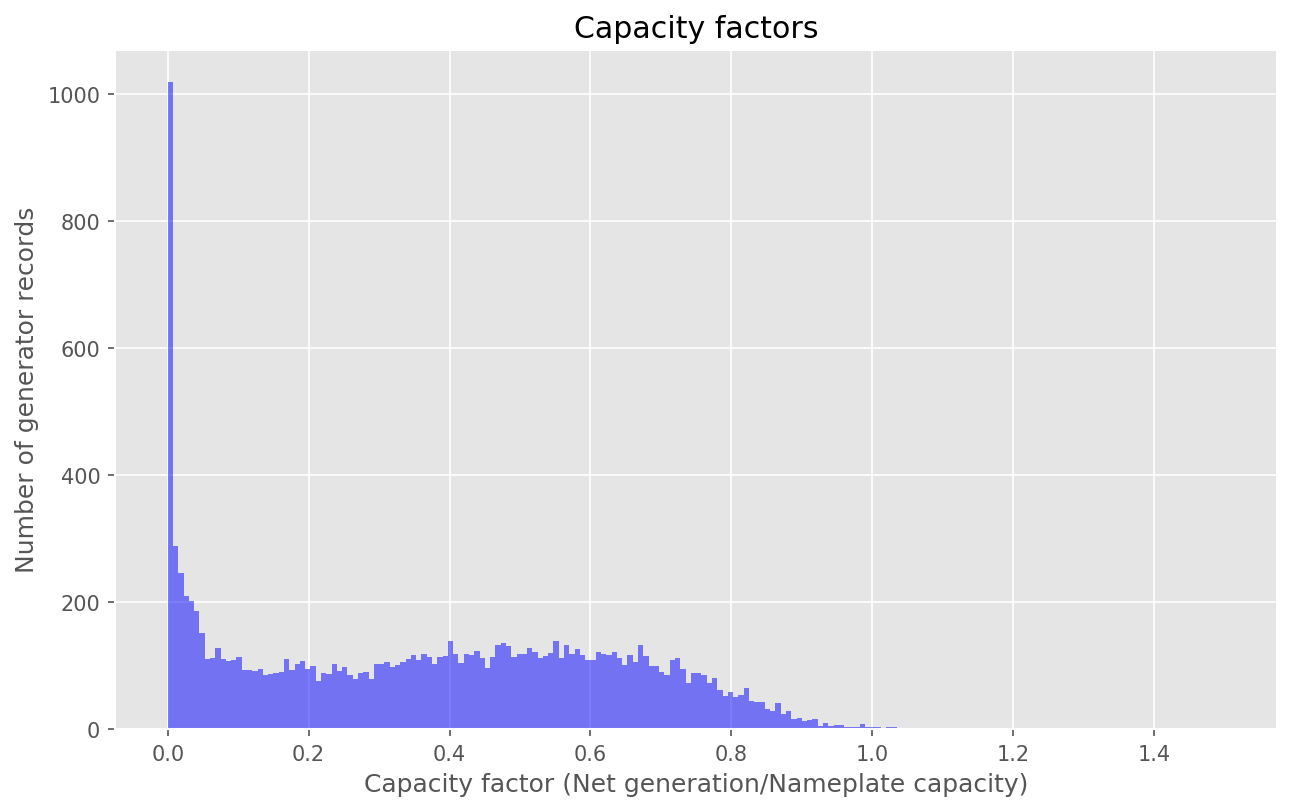

In [50]:
#quick look at capacity factors
plt.hist(mcoe_by_generator.capacity_factor, range=(0,1.5), bins=200, alpha=0.5, color='blue')
plt.xlabel("Capacity factor (Net generation/Nameplate capacity)")
plt.ylabel("Number of generator records")
plt.title("Capacity factors")
plt.legend();

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)
/home/alana/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


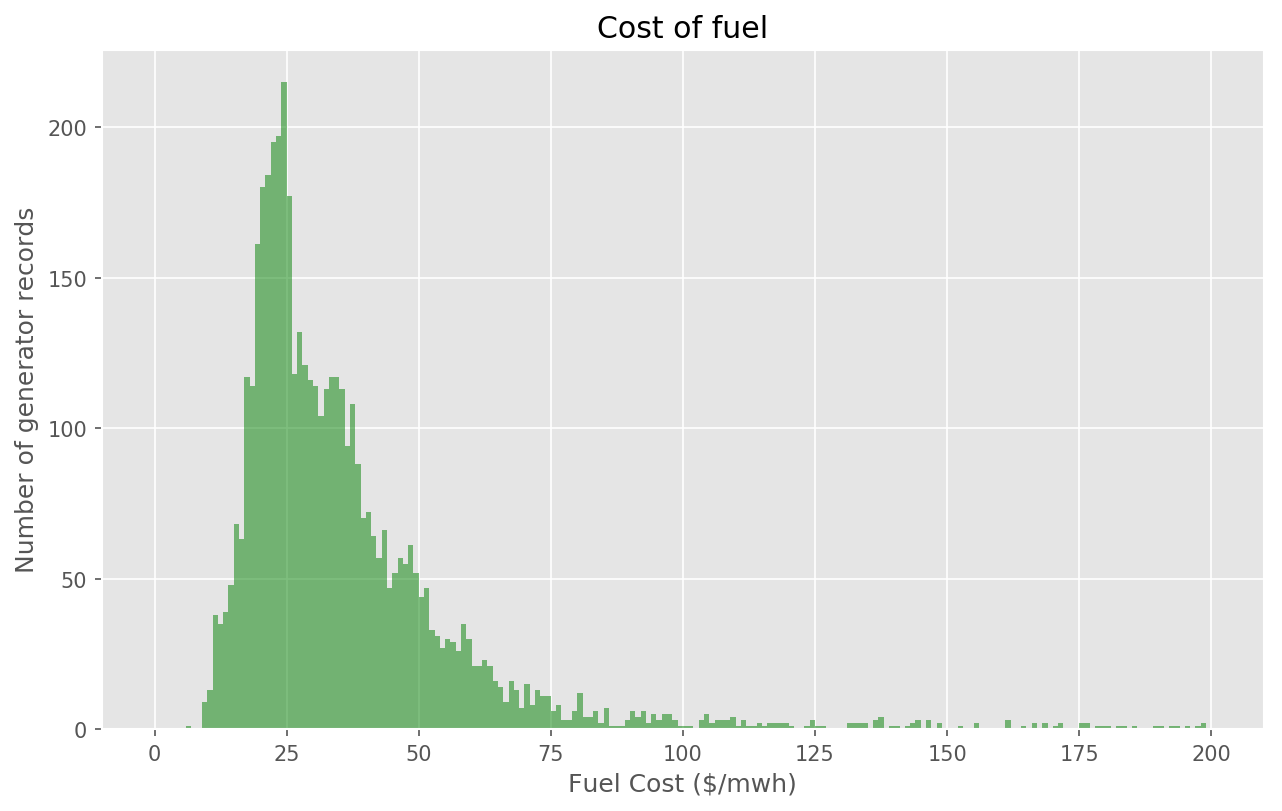

In [51]:
#quick look at spread in fuel_cost_per_mwh for these plants
plt.hist(mcoe_by_generator.fuel_cost_per_mwh, range=(0,200), bins=200, alpha=0.5, color='green')
plt.xlabel("Fuel Cost ($/mwh)")
plt.ylabel("Number of generator records")
plt.title("Cost of fuel")
plt.legend()

# Pull in FERC data & identify plants with simple

In [92]:
simple_ferc = analysis.simple_ferc1_plant_ids(pudl_engine)

In [93]:
simple_ferc = simple_ferc.iloc[:,0]

In [73]:
# ferc_expenses returns:
# ferc1_expns_corr: A dictionary of expense categories
#             and their correlations to the plant's net electricity generation.
# steam_df: a dataframe with all the operating expenses broken out for each simple FERC PUDL plant.

In [95]:
ferc_expenses = analysis.ferc_expenses(pudl_engine, simple_ferc)

In [98]:
ferc_expenses[1]

,report_year,respondent_id,util_id_pudl,respondent_name,plant_id_pudl,plant_name,total_capacity_mw,year_constructed,year_installed,peak_demand_mw,...,expns_allowances,expns_engineering,expns_structures,expns_boiler,expns_plants,expns_misc_steam,expns_production_total,expns_per_mwh,expns_total_nonfuel_production,expns_total_nonproduction
4,2004,2,18,ALABAMA POWER COMPANY,227,Gorgas,1416.70,1929.0,1972.0,1233.0,...,4642951.0,2487427.0,3081447.0,16596930.0,3410896.0,588617.0,187426281.0,23.7,37423489.0,11867605.0
5,2004,2,18,ALABAMA POWER COMPANY,204,Gadsden,138.00,1949.0,1949.0,744.0,...,516904.0,367710.0,426909.0,1811727.0,400661.0,145879.0,20752500.0,41.0,5304214.0,1957158.0
8,2004,2,18,ALABAMA POWER COMPANY,293,Joseph M. Farley,1776.50,1977.0,1981.0,1488.0,...,0.0,6927010.0,2502635.0,33326524.0,5633532.0,5408993.0,205497796.0,15.6,84814171.0,59874240.0
16,2004,2,18,ALABAMA POWER COMPANY,617,Washington County,122.58,1999.0,1999.0,122.0,...,0.0,262236.0,61030.0,0.0,2750855.0,62190.0,54331203.0,76.1,4598215.0,361937.0
18,2004,2,18,ALABAMA POWER COMPANY,580,Theodore,273.87,2000.0,2000.0,232.0,...,0.0,168965.0,312938.0,0.0,1012093.0,48431.0,73105267.0,56.6,2564409.0,572452.0
20,2004,3,19,Alaska Electric Light and Power Company,322,Lemon Creek,22.50,1969.0,1985.0,23.0,...,0.0,0.0,0.0,0.0,126710.0,0.0,196100.0,474.9,126710.0,29582.0
21,2004,3,19,Alaska Electric Light and Power Company,322,Lemon Creek,35.00,1980.0,1983.0,35.0,...,0.0,0.0,0.0,0.0,87305.0,0.0,242112.0,403.5,87305.0,43706.0
22,2004,3,19,Alaska Electric Light and Power Company,28,Auke Bay,2.50,1983.0,1983.0,3.0,...,0.0,0.0,0.0,0.0,31974.0,0.0,33918.0,2691.9,31974.0,661.0
23,2004,3,19,Alaska Electric Light and Power Company,28,Auke Bay,25.80,1993.0,1994.0,26.0,...,0.0,0.0,0.0,0.0,45205.0,0.0,143234.0,272.2,45205.0,27589.0
24,2004,6,29,Appalachian Power Company,112,Clinch River,712.50,1958.0,1961.0,713.0,...,1307808.0,1117900.0,379269.0,8995553.0,1212654.0,933502.0,80299354.0,20.4,17046690.0,3466970.0
